# SAGE GAGE 2025 SIG Demo:  
![](https://www.earthscope.org/app/uploads/2024/11/2025_conference_banner-1024x333.webp)
### GeoLab processing EarthScope GNSS $ARCO_{*1}$ data in $S3_{*2}$

*1  ARCO =  Analysis ready, cloud optimized

*2 S3 is AWS object storage (simple storage service)

Goal:
Demonstrate multiple methods for processing GNSS observation data in the SAGE/GAGE GeoLab in AWS

Comparisons:
1. Serial download and process: in GeoLab
2. Serial read from S3 and process: in GeoLab
3. Parallel read and process using Dask-Gateway in GeoLab


In [1]:
import boto3 
import time
from datetime import datetime, timedelta
import numpy as np
import tiledb
import os

from dask.distributed import Client
from dask.distributed import LocalCluster
import dask, dask.array
from dask_gateway import Gateway

import matplotlib.pyplot as plt

import requests
from pathlib import Path
 
from earthscope_sdk.auth.device_code_flow import DeviceCodeFlowSimple
from earthscope_sdk.auth.auth_flow import NoTokensError

def unix_time_millis(dt):
    epoch = datetime.utcfromtimestamp(0)
    return int((dt - epoch).total_seconds() * 1e3)

def utc_time(dt):
    epoch = datetime.utcfromtimestamp(0)
    return timedelta(seconds=dt*1e-3) + epoch

def get_es_file(url, directory_to_save_file='./', token_path='./'):
    """function to get earthscope data using es-sdk
    modified from https://gitlab.com/earthscope/public/earthscope-sdk

    Parameters
    ----------
    url : string
        url of desired file at gage-data.earthscope.org
    directory_to_save_file : str, optional
        path of directory in which to save the file, by default cwd
    token_path : str, optional
        path of directory in which to save the token, by default './'
    """
    # instantiate the device code flow subclass
    device_flow = DeviceCodeFlowSimple(Path(token_path))
    try:
      # get access token from local path
      device_flow.get_access_token_refresh_if_necessary()
    except NoTokensError:
      # if no token was found locally, do the device code flow
      device_flow.do_flow()
    token = device_flow.access_token

    # request a file and provide the token in the Authorization header
    file_name = Path(url).name

    r = requests.get(url, headers={"authorization": f"Bearer {token}"})
    if r.status_code == requests.codes.ok:
      # save the file
      with open(Path(Path(directory_to_save_file) / file_name), 'wb') as f:
          for data in r:
              f.write(data)
    else:
      #problem occured
      print(f"failure: {r.status_code}, {r.reason}")

In [2]:
%pip install georinex

Note: you may need to restart the kernel to use updated packages.


## 1. Serial download RINEX and process 'Traditional Method'

downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2024/001/p0570010.24d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2024/002/p0570020.24d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2024/003/p0570030.24d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2024/004/p0570040.24d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2024/005/p0570050.24d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2024/006/p0570060.24d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2024/007/p0570070.24d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2024/008/p0570080.24d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2024/009/p0570090.24d.Z


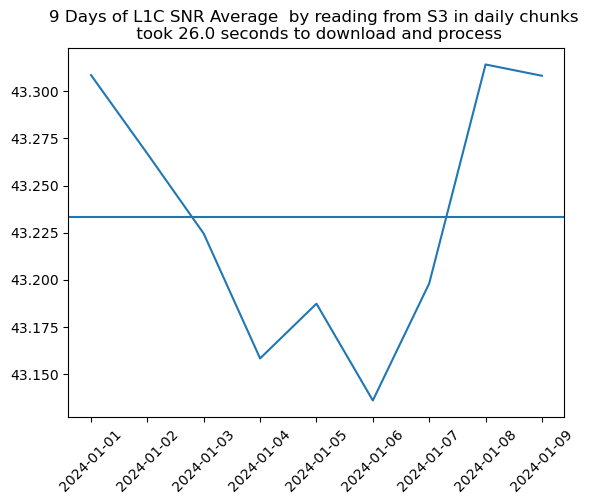

In [4]:
import georinex as gr #https://github.com/geospace-code/georinex/blob/main/Readme_OBS.md
import os

directory_path = "./rinex_data"
os.makedirs(directory_path, exist_ok=True)

dl_time=[]
pr_time=[]
snr_li=[]
date_li=[]
year=2024

start_t = time.time()
for doy in np.arange(1,10):
    #download
    url='https://gage-data.earthscope.org/archive/gnss/rinex/obs/2024/%03d/p057%03d0.24d.Z' %(doy,doy)
    print('downloading: ', url)
    get_es_file(url, 'rinex_data')
    
    #process
    fn='rinex_data/p057%03d0.24d.Z' %doy
    # Use Georinex to convert Rinex _> Xarray Dataframe
    obs = gr.load(fn, use='G', meas=['S1'])
    g=obs['S1'].mean().values
    snr_li+=[g]
    date_li+=[datetime(year, 1, 1) + timedelta(days=int(doy - 1))]
    #delete the file
    os.remove(fn)
    
end_t = time.time()
dl_time=end_t-start_t

snr_rnx=np.mean(snr_li)

# Plot results ##########
plt.plot(date_li, snr_li)
plt.xticks(rotation=45)
plt.axhline(snr_rnx)
plt.title('%s Days of L1C SNR Average  by reading from S3 in daily chunks \n took %.1f seconds to download and process' %(len(date_li),dl_time))
plt.show()

## What is this doing?

1. Downloading GNSS Observations
![](https://customersupport.septentrio.com/servlet/rtaImage?eid=ka04y000000CyrT&feoid=00Nf3000002xZ3u&refid=0EMf3000000qixY)

(credit: Septentrio)

2. Community bespoke python decoder: GeoRinex
   
![](../images/gr.png)

3. Using Xarray to slice/average
   
![](https://docs.xarray.dev/en/stable/_static/Xarray_Logo_RGB_Final.svg)


# ARCO GNSS Objects:  Read from TileDB in S3

In [5]:
!aws sso login --profile es-dev

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://oidc.us-east-2.amazonaws.com/authorize?response_type=code&client_id=ZwqJXaiRTqTLDQOd-QjNBnVzLWVhc3QtMg&redirect_uri=http%3A%2F%2F127.0.0.1%3A52743%2Foauth%2Fcallback&state=b8513a04-d15d-4694-b35d-8cd8d4f00a81&code_challenge_method=S256&scopes=sso%3Aaccount%3Aaccess&code_challenge=LJc4ce6a_8IwmC8ldjSNrN8kPffXSPTEh7c-734kGUY
Successfully logged into Start URL: https://d-9a672d0f17.awsapps.com/start#/


In [6]:
session=boto3.Session(profile_name='es-dev')
credentials=session.get_credentials()
credentials=credentials.get_frozen_credentials()

tdb_config={"vfs.s3.region": "us-east-2", "sm.io_concurrency_level": 12, 
                                              "vfs.s3.aws_access_key_id":credentials.access_key, "vfs.s3.aws_secret_access_key":credentials.secret_key,
                                             "vfs.s3.aws_session_token":credentials.token}

In [7]:
pnum='P057'  #using datasources-api https://datasources-api.dev.earthscope.org/docs#/Stream/Stream-find_streams
edid="01GVDXYKWXCFP2N5WAJN4CX36F"
year=2024
start_time='2024-05-11'
duration='12' #hours  
constell= 0 #'GPS'
obs_code=12611 #L1C   int(12611).to_bytes(2, 'big').decode("utf-8")

bucket='s3://repository-stage-us-east-2-mlmoghi3ooss/gnss/obs/tiledb/'

uri=bucket+edid

start_date=datetime.fromisoformat(start_time)
durationz=timedelta(hours=int(duration)) #1hour
end_date=start_date+durationz

In [8]:
%%time
# With pandas
with tiledb.open(uri,mode="r", config=tdb_config,) as A:
    # note that array indexes are half-open like NumPy
    df = A.df[unix_time_millis(start_date): unix_time_millis(end_date),constell,:,obs_code]

TileDBError: [TileDB::Array] Error: Cannot open array; Array does not exist.

In [ ]:
print(df.shape)
df.head()

In [ ]:
df[df.sat==3].snr.plot()

# 2. Serial read from S3 and process: in GeoLab

Our second strategy...

In [ ]:
%%time
start_t = time.time()

snr_li=[]
date_li=[]
for doy in np.arange(1,51):
    start=datetime(year, 1, 1) + timedelta(days=int(doy - 1))
    date_li+=[start]
    end=start+timedelta(days=1)
    start=unix_time_millis(start)
    end=unix_time_millis(end)
  
    with tiledb.open(uri,mode="r", config=tdb_config,) as A:
        df=A.df[slice(int(start), int(end)),constell,:,obs_code]['snr']
        snr_li+=[df.mean()]
        
for_loop=np.nanmean(np.array(snr_li))

end_t = time.time()
for_loop_t=end_t - start_t

# Plot results
plt.plot(date_li, snr_li)
plt.axhline(for_loop)
plt.xticks(rotation=45)
plt.title('%s Days of L1C SNR Average \n by reading from S3 in daily chunks took %.1f seconds' %(len(date_li),for_loop_t))
plt.show()

![](../images/ar.png)
credit: R. Abernathy/ Pangeo Project

https://speakerdeck.com/rabernat/beyond-fair-what-data-infrastructure-does-open-science-need?slide=33

![](../images/co.png)
credit: R. Abernathy/ Pangeo Project

https://speakerdeck.com/rabernat/beyond-fair-what-data-infrastructure-does-open-science-need?slide=33

# 3. Parallel read and process using Dask-Gateway in GeoLab

our final comparison demo

In [ ]:
gateway = Gateway()  # Uses values configured for the 2i2c Dask hub (recommended)

options = gateway.cluster_options()
options

In [ ]:
# Create and scale gateway cluster
cluster = gateway.new_cluster(options)
cluster

In [ ]:
#Connect to the gateway cluster
client = cluster.get_client()
client

In [194]:
# Get schema and Non-empty domain of Tdb object:
with tiledb.open(uri,mode="r", config=tdb_config,) as A:
    ned=A.nonempty_domain()
    #print(A.schema)

# What is this doing?

![](https://docs.2i2c.org/_images/scalable_research_hub.png)

Credit: 2i2c

https://docs.2i2c.org/about/distributions/research/

In [ ]:
start_t = time.time()
# This produces an array slice
def slice_tiledb(path, slc):
    with tiledb.open(uri,mode="r", config=tdb_config,) as A:
        return A[slc,0,:,12611]['snr']
       

# Partition the array into delayed slices
chunk = 43200000*4 # tile size?
delayed_slices = list(
    dask.delayed(slice_tiledb)(uri, slice(int(start), int(start+chunk))) for 
                               start in 
                               np.arange(ned[0][0],ned[0][1]-chunk,step=chunk)) #-86400*1e3

# This creates a Dask array from the delayed slices
darray = dask.array.concatenate(
    dask.array.from_delayed(x,
                            shape=(chunk,), dtype=np.float64)
                            for x in delayed_slices)

#Everything up until here is lazy - nothing is really computed

# This triggers the entire computation
#darray.persist()
gw_cluster = darray.mean().compute()

end_t = time.time()
gw_cluster_t=end_t - start_t

print('Object start date: ',utc_time(ned[0][0]))
print('Object end date: ',utc_time(ned[0][1]))

days_p=(ned[0][1]-ned[0][0])/(86400e3)
print('Processing %.01f days took %.01f seconds' %(days_p,gw_cluster_t))

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
plt.bar(["Download and process: in GeoLab",
        "S3 and process: in GeoLab","Dask-Gateway in GeoLab"],
        [9,50,440])
plt.title("Amount of Days of GNSS Data Processed in about 30 seconds")
plt.xticks(rotation=90)
plt.show()

## Takeaways:

1. Reading from s3 doesn't require local copies of data flying around
    * imagine slow internet
    * FAIR data principles
3. **Analysis Ready** data doesn't require maintenance of bespoke data format decoders (georinex, obspy/mseed, etc)
    * open source libraries built upon mature data containers
5. A cloud-hosted notebook compute interface adjacent to the cloud data provides effecient data discovery and exploratory analysis
6. A distributed compute infrastructure (dask-gateway) adjacent to ARCO data supports high throughput, massively parallelizable workflows
    * large scale data analysis
    * Machine learning + deep learning

In [197]:
cluster.close()